In [72]:
import Analysis_Code.discrete_quantum as dq
from Analysis_Code.useful import *
from Analysis_Code.iplots import *

from numpy import empty, arange, zeros, mean, std, linspace, random, diag, array, ones, logspace
import numpy as np
from numba import njit
from timeit import *
from tqdm import tqdm

from unipolator import *
from kronbinations import *

import os
import matplotlib.pyplot as plt
import tikzplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}"])})

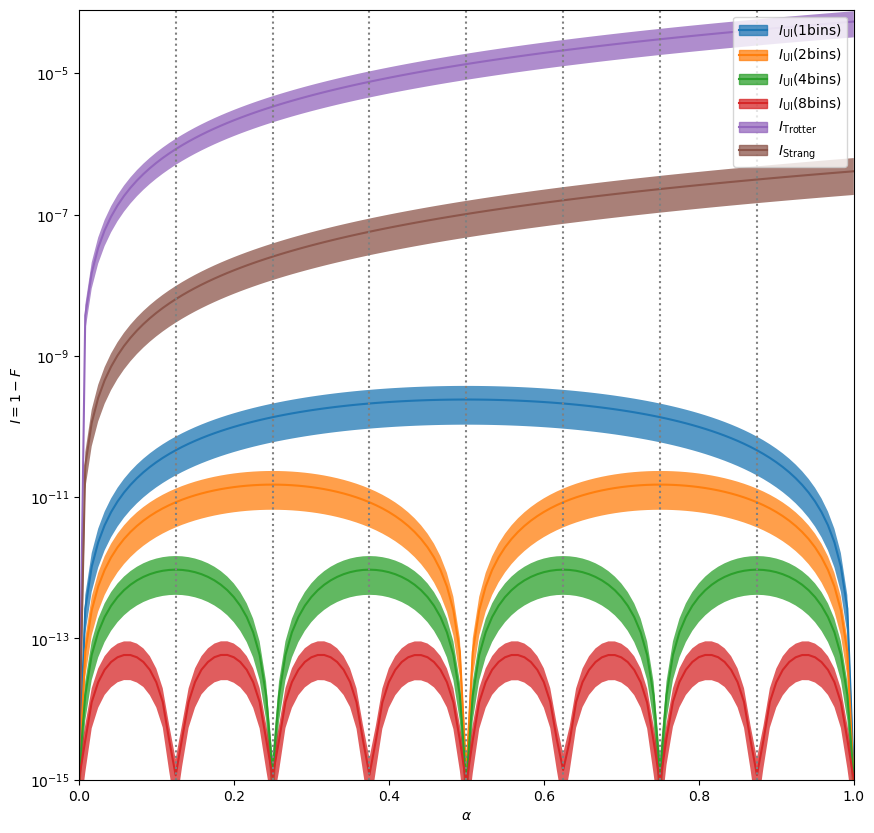

# Generated missing folder: Infidelity

————— filename —————————————————————————————————————————————————————————————————
Infidelity\one_d_1_bins_infidelity_comparison_std_plot_log.tex


In [2]:
# 1D interpolation vs Trotter and Strang, with distribution
n = 1 # 1D interpolation
extreme = 0
s = 4
bins = array([1,2,4,8])
mini = 0.0
maxi = 1.0
do_figures = 1
rng = random.default_rng(123)
markersize = 4
width = 8.5
reps = 100
plot_log = 1 # 1=semilogy; 2=loglog
ps = 0.68
ns = 1
both_plots = False

c_mins = ones(n)*mini
c_maxs = ones(n)*maxi

U_ui = empty([s,s], dtype=complex)
U_sym = empty([s,s], dtype=complex)
U_classic = empty([s,s], dtype=complex)
U_trotter = empty([s,s], dtype=complex)
U_strang = empty([s,s], dtype=complex)

how_many = 8*15+1
c_s = linspace(mini,maxi,how_many)
lim2 = 1.0
how_many2 = how_many
c_s2 = linspace(0,lim2,how_many2)
n_bins = len(bins)

I = empty([reps, n_bins, how_many])
I_sym = empty([reps, n_bins, how_many])
dI = empty([reps, n_bins, how_many])
I_trotter = empty([reps, how_many2])
I_strang = empty([reps, how_many2])

for rep in range(reps):
    if extreme == 0:
        amps = array([1.0, 0.05])
    else:
        amps = array([1.0, 20.0])
    H_s = Random_parametric_Hamiltonian_Haar(n, s, amps, rng=rng)

    ui = []
    sym_ui = []
    for i, bin in enumerate(bins):
        c_bins = bin*np.ones(n, dtype=int)
        # Prepare interpolations and exact decompositions
        ui.append(UI(H_s, c_mins, c_maxs, c_bins))
        sym_ui.append(Sym_UI(H_s, c_mins, c_maxs, c_bins))
    system = Hamiltonian_System(H_s)
    trotter = Trotter_System(H_s)
    strang = Sym_Trotter_System(H_s)
    for i, d in enumerate(c_s):
        c = np.array([d]) #np.random.random(n)
        system.expmH(c, U_classic)
        # 1 Bin
        for j in range(len(bins)):
            ui[j].expmH(c, U_ui)
            sym_ui[j].expmH(c, U_sym)
            I[rep,j,i] = Av_Infidelity(U_ui, U_classic)
            I_sym[rep,j,i] = Av_Infidelity(U_sym, U_classic)
            dI[rep,j,i] = Av_Infidelity(U_sym, U_ui)
    for i, d in enumerate(c_s2):
        c = np.array([d]) #np.random.random(n)
        system.expmH(c, U_classic)
        trotter.expmH(c, U_trotter)
        strang.expmH(c, U_strang)
        I_trotter[rep,i] = Av_Infidelity(U_trotter, U_classic)
        I_strang[rep,i] = Av_Infidelity(U_strang, U_classic)
# Extract mean and std from the repetitions
I_mean = mean(I, axis=0)+10**-16
I_std = std(I, axis=0)
I_sym_mean = mean(I_sym, axis=0)+10**-16
I_sym_std = std(I_sym, axis=0)
dI_mean = mean(dI, axis=0)
dI_std = std(dI, axis=0)
I_trotter_mean = mean(I_trotter, axis=0)+10**-16
I_trotter_std = std(I_trotter, axis=0)
I_strang_mean = mean(I_strang, axis=0)+10**-16
I_strang_std = std(I_strang, axis=0)

# Plot the results
figsize = np.array([10,10])  # width, height
ratios = np.array([3,1])
if both_plots:
    figs, axs = subplotter2multifigure(do_figures, figsize, ratios)
    ax1, ax2 = axs
else: # only one axis
    figs = plt.figure(figsize=figsize)
    ax1 = figs.add_subplot(111)

legendary = []
for j, bin in enumerate(bins):
    legendary, mini = std_plot(ax1, c_s, [I_mean[j,:]], [I_std[j,:]], ps=ps, ns=ns, label=r'$I_{\mathrm{UI}}(\mathrm{'+str(bin)+' bins})$', legendary=legendary, colors='C'+str(j), support=[10**-16,1.0])
if both_plots:
    ax1.set(xticks=[], xlim=[mini, maxi], ylabel=r'$I=1-F$')
else:
    ax1.set(xlim=[mini, maxi], ylabel=r'$I=1-F$', xlabel=r'$\alpha$')
legendary, mini = std_plot(ax1, c_s2, [I_trotter_mean], [I_trotter_std], ps=ps, ns=ns, label=r'$I_{\mathrm{Trotter}}$', legendary=legendary, colors='C'+str(n_bins), support=[10**-16,1.0])
legendary, mini = std_plot(ax1, c_s2, [I_strang_mean], [I_strang_std], ps=ps, ns=ns, label=r'$I_{\mathrm{Strang}}$', legendary=legendary, colors='C'+str(n_bins+1), support=[10**-16,1.0])
ax1.legend(*legendary, loc='upper right')
y_lim = ax1.get_ylim()
if plot_log >= 1:
    ax1.set(ylim=[10**-15, y_lim[1]], yscale='log')
    logstr = '_log'
    if plot_log == 2: # Lolog
        ax1.set(xlim=[10**-2, maxi], xscale='log')
        logstr = '_loglog'
else:
    ax1.set(ylim=[0, y_lim[1]])
    logstr = ''
if y_lim[1]*1.15 > 1-1/(s+1):
    ax1.hlines(1-1/(s+1), mini, maxi, linestyles='dotted', colors='black', zorder=-1)
for i in range(1,max(bins)):
    ax1.axvline(i/max(bins), color='gray', linestyle='dotted')
if not both_plots:
    plt.show()
    if do_figures:
        folder = 'Infidelity'
        filename = 'one_d_'+str(bins[0])+'_bins_infidelity_comparison_std_plot'+logstr+'.tex'
        subfig_str = figs2tikz([figs], folder, filename, ratios, figsize, width=width, standalone=False, add_letters=0)
        print(subfig_str)
        line('filename')
        print(os.path.join(folder, filename))
else:
    for j, bin in enumerate(bins):
        legendary, mini = std_plot(ax2, c_s, [dI_mean[j,:]], [dI_std[j,:]], ps=ps, ns=ns, label=r'$I_{\mathrm{Strang}}$', legendary=legendary, colors='C'+str(j), support=[10**-16,1.0])
    ax2.set(xlim=[mini, maxi], xlabel='c', ylabel=r'$I(U_{\mathrm{UI}}, U_{\mathrm{Sym}})$')
    plt.show()
    if do_figures:
        if extreme == 0:
            subfig_str = figs2tikz(figs, 'Infidelity', 'one_d_'+str(bins[0])+'_bins_infidelity_comparison_std_plot'+logstr+'.tex', ratios, figsize, width=width, standalone=False, add_subfig=True)
        else:
            subfig_str = figs2tikz(figs, 'Infidelity', 'one_d_'+str(bins[0])+'_bins_infidelity_comparison_extreme_case_std_plot'+logstr+'.tex', ratios, figsize, width=width, standalone=False, add_subfig=True)
        print(subfig_str)

100%|██████████| 10000/10000 [01:14<00:00, 135.09it/s]


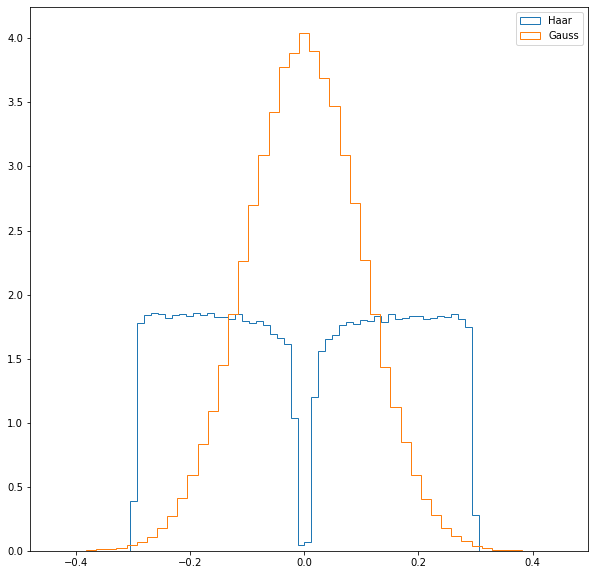

In [10]:
from scipy.linalg import eigh
from tqdm import tqdm
rng = random.default_rng(100)

nbins = 50
s = 32
reps = 10000

E_Haar = empty([reps, s])
E_gauss = empty([reps, s])
for i in tqdm(range(reps)):
    H = randH_Haar(s, 1.0, rng)
    E_Haar[i,:], _ = eigh(H)
    H = randH_gauss(s, 0.0, 0.1, rng)
    E_gauss[i,:], _ = eigh(H)

figsize = np.array([10,10])  # width, height
fig, ax1 = plt.subplots(1, 1, figsize=figsize)
a = ax1.hist(E_Haar.flatten(), bins=nbins, histtype=u'step', density=True, label='Haar')
b = ax1.hist(E_gauss.flatten(), bins=nbins, histtype=u'step', density=True, label='Gauss')
ax1.legend()

In [18]:
from useful import *
from discrete_quantum import *
import discrete_quantum as dq
from numpy import empty, arange, zeros, mean, std, linspace, random, diag, array
import numpy as np
from numba import njit
from timeit import *
from tqdm import tqdm
from kronbinations import *

from unipolator import *

import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}"])})

NameError: name 'fig' is not defined

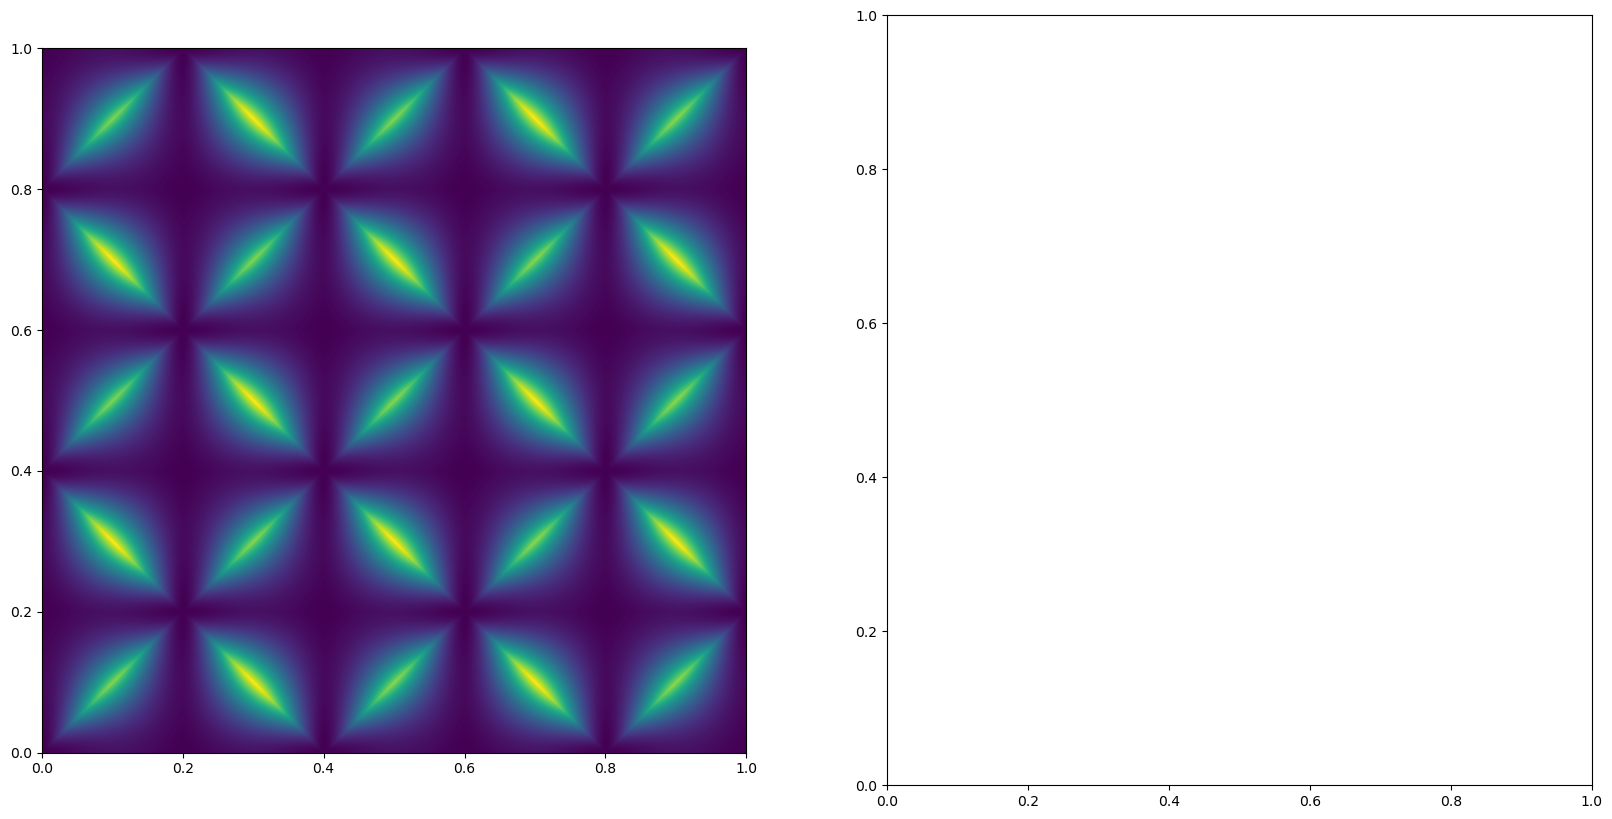

In [76]:
n = 2 # 2D interpolation logarithmic
bins = 5
s = 4
do_figures = 1 # required for this one
figsize = np.array([20,10])  # width, height
ratios = np.array([1, 1])
how_many = 1000
width = 7.0

def infidelities_2d(k, bins, n, s, I, I_sym, rng):
    amps = np.array([1.0, 0.1])
    H_s = dq.Random_parametric_Hamiltonian_Haar(n, s, amps, rng=rng)
    c_mins = np.ones(n) * 0
    c_maxs = np.ones(n) * 1.0
    c_bins = bins*np.ones(n, dtype=int)
    ui = UI(H_s, c_mins, c_maxs, c_bins)
    sym_ui = Sym_UI(H_s, c_mins, c_maxs, c_bins)
    system = Hamiltonian_System(H_s)

    U = np.empty([s,s], dtype=complex)
    U_sym = np.empty([s,s], dtype=complex)
    U_classic = np.empty([s,s], dtype=complex)
    for i, (d,e) in k.kronprod(change=False, progress=True):
        c = np.array([d, e]) #np.random.random(n-1)
        ui.expmH(c, U)
        sym_ui.expmH(c, U_sym)
        system.expmH(c, U_classic)
        I[i] = dq.Av_Infidelity(U, U_classic)
        I_sym[i] = dq.Av_Infidelity(U_sym, U_classic)
    return I, I_sym
c_s = np.linspace(0.0, 1.0 ,how_many)
k = JIT_kronbinations(c_s, c_s, func=infidelities_2d, import_statements=[['discrete_quantum', 'dq'], 'unipolator'], other_arguments=[bins, n, s])
I = k.empty()
I_sym = k.empty()

figs, axs = plt.subplots(1, 2, figsize=figsize)
# subplotter2multifigure(do_figures, figsize, ratios, horizontal=True)
ax1, ax2 = axs
labels = [r'$I$', r'$I_\mathrm{sym}$']
Is = [I, I_sym]
#max_I = max([I.max(), I_sym.max()])
for ax, label, cI  in zip(axs, labels, Is): #, figs): fig
    p = ax.imshow(cI.array(), extent=(0.0, 1.0, 0.0, 1.0), interpolation='spline16', origin='lower') #, norm=LogNorm()
    #p.set_clim(10**-15, max_I)
    fig.colorbar(p, ax=ax, label=label, fraction=0.046, pad=0.04)#, orientation='horizontal')
    # Horizontal and Vertical plots
    for i in range(bins+1):
        c = 1/bins*i
        ax.plot([0.0, 1.0], [c, c], color='C0', linestyle='dotted')
        ax.plot([c, c], [0.0, 1.0], color='C0', linestyle='dotted')
    # Diagonal plots
    for i in range(0,2*bins+1, 2):
        c =  1/bins*i
        c2 =  1/bins*(i - bins - 1)
        ax.plot([c, 0], [0, c], color='C1', linestyle='dotted')
        ax.plot([c2, c2 + 1.0], [0.0, 1.0], color='C1', linestyle='dotted')
    ax.set(xlabel=r'$c_0$', ylabel=r'$c_1$', xlim=[0.0, 1.0], ylim=[0.0, 1.0])
plt.set_cmap('viridis')
#if do_figures:
#    subfig_str = figs2tikz(figs, 'Infidelity', 'two_d_'+str(bins)+'_bins_infidelity_comparison_extreme_case.tex', ratios, figsize, width=width, standalone=False, add_subfig=True, horizontal=True)
#    print(subfig_str)

4.039231434449508e-11 4.213767246989153e-11


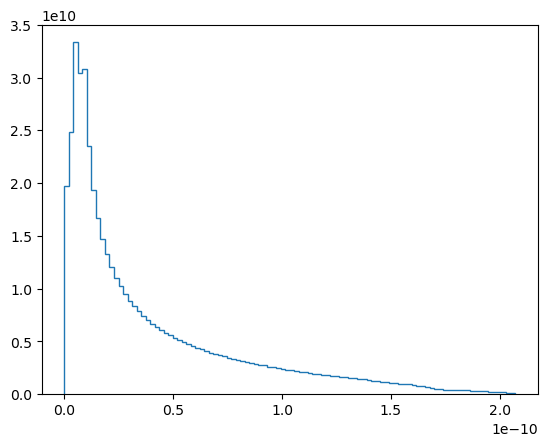

In [78]:
I_ui = I.array().flatten()
# plot histogram
A = plt.hist(I_ui, bins=100, histtype=u'step', density=True, label='UI')
print(np.mean(I_ui), np.std(I_ui))

\begin{figure*}[t]
  \begin{subfigure}[b]{0.5\texwidth}
    \includetikz{Infidelity}{two_d_5_bins_infidelity_comparison_0}
  \end{subfigure}
  \begin{subfigure}[b]{0.5\texwidth}
    \includetikz{Infidelity}{two_d_5_bins_infidelity_comparison_1}
  \end{subfigure}
\end{figure*}


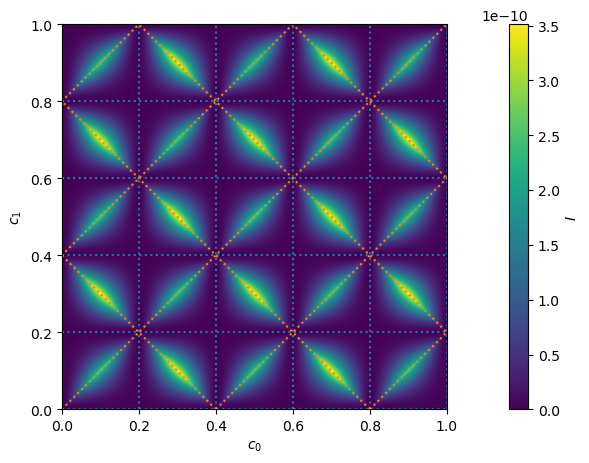

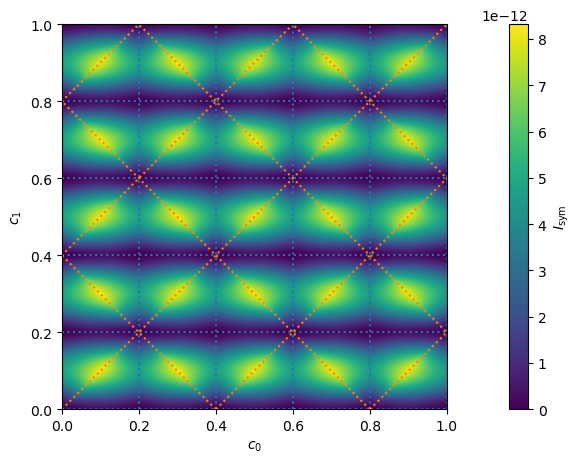

In [6]:
n = 2 # 2D interpolation
s = 4
bins = 5
mini = 0 #-1.4
maxi = 1.0
rng = random.default_rng(102)
do_figures = 1 # required for this one
extreme = 0
figsize = np.array([20,10])  # width, height
ratios = np.array([1, 1])

how_many = 1000
width = 7.0

amps = array([1.0, 0.1])
H_s = Random_parametric_Hamiltonian_Haar(n, s, amps, rng=rng)

c_mins = np.ones(n) * mini
c_maxs = np.ones(n) * maxi
c_bins = bins*np.ones(n, dtype=int)
ui = UI(H_s, c_mins, c_maxs, c_bins)
sym_ui = Sym_UI(H_s, c_mins, c_maxs, c_bins)
system = Hamiltonian_System(H_s)

U = np.empty([s,s], dtype=complex)
U_sym = np.empty([s,s], dtype=complex)
U_classic = np.empty([s,s], dtype=complex)

c_s = np.linspace(mini, maxi ,how_many)
I = np.empty([how_many, how_many])
I_sym = np.ones([how_many, how_many])
for i, d in enumerate(c_s):
    for j, e in enumerate(c_s):
        c = np.array([d, e]) #np.random.random(n-1)
        ui.expmH(c, U)
        sym_ui.expmH(c, U_sym)
        system.expmH(c, U_classic)
        I[i, j] = Av_Infidelity(U, U_classic)
        I_sym[i, j] = Av_Infidelity(U_sym, U_classic)

figs, axs = subplotter2multifigure(do_figures, figsize, ratios, horizontal=True)
ax1, ax2 = axs
labels = [r'$I$', r'$I_\mathrm{sym}$']
Is = [I, I_sym]
for ax, label, cI, fig in zip(axs, labels, Is, figs):
    p = ax.imshow(cI, extent=(mini, maxi, mini, maxi), interpolation='spline16', vmin=0, origin='lower')
    fig.colorbar(p, ax=ax, label=label, fraction=0.046, pad=0.04)#, orientation='horizontal')
    # Horizontal and Vertical plots
    for i in range(bins+1):
        c = mini + (maxi-mini)/bins*i
        ax.plot([mini, maxi], [c, c], color='C0', linestyle='dotted')
        ax.plot([c, c], [mini, maxi], color='C0', linestyle='dotted')
    # Diagonal plots
    for i in range(0,2*bins+1, 2):
        c = mini + (maxi-mini)/bins*i
        c2 = mini + (maxi-mini)/bins*(i - bins - 1)
        ax.plot([c, mini], [mini, c], color='C1', linestyle='dotted')
        ax.plot([c2, c2 + maxi-mini], [mini, maxi], color='C1', linestyle='dotted')
    ax.set(xlabel=r'$c_0$', ylabel=r'$c_1$', xlim=[mini, maxi], ylim=[mini, maxi])
plt.set_cmap('viridis')
if do_figures:
    if extreme == 0:
        subfig_str = figs2tikz(figs, 'Infidelity', 'two_d_'+str(bins)+'_bins_infidelity_comparison.tex', ratios, figsize, width=width, standalone=False, add_subfig=True, horizontal=True)
    else:
        subfig_str = figs2tikz(figs, 'Infidelity', 'two_d_'+str(bins)+'_bins_infidelity_comparison_extreme_case.tex', ratios, figsize, width=width, standalone=False, add_subfig=True, horizontal=True)
    print(subfig_str)

In [2]:
from useful import *
import discrete_quantum as dq
from numpy import ones, empty, arange, zeros, mean, std, linspace, random, diag, array, logspace
import numpy as np
from numba import njit
from timeit import *
from tqdm import tqdm

from unipolator import *
from iplots import std_plot

————————————————————————————————————————————————————————————————————————————————


100%|██████████| 7/7 [00:24<00:00,  3.46s/it]


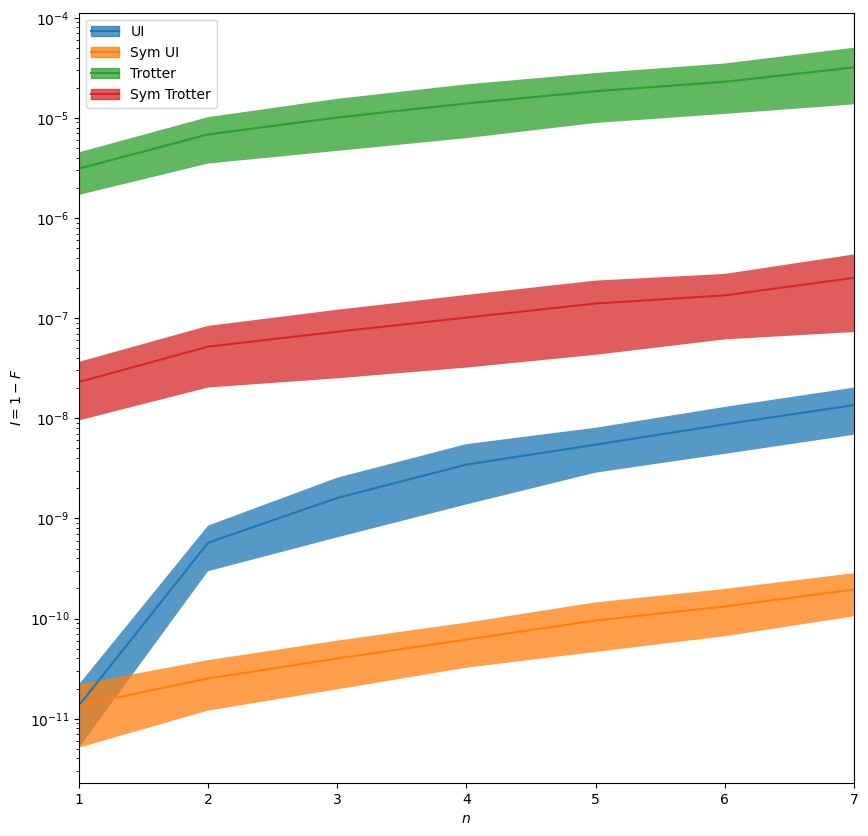

In [7]:
n_list = arange(1,8)
I_ui, I_sym_ui, I_trotter, I_sym_trotter = [[] for i in range(4)]
std_I_ui, std_I_sym_ui, std_I_trotter, std_I_sym_trotter = [[] for i in range(4)]
reps = 100
rng = random.default_rng(100)
ps = 0.68
ns = 1

s = 4
bins = 1
interval = 1.0
U_exact = empty([s,s], dtype=complex)
U_ui = empty([s,s], dtype=complex)
U_sym_ui = empty([s,s], dtype=complex) 
U_trotter = empty([s,s], dtype=complex)
U_sym_trotter = empty([s,s], dtype=complex)
line()
how_many = len(n_list)
for n in tqdm(n_list):
    curr_I = empty(reps)
    curr_I_sym = empty(reps)
    curr_I_trotter = empty(reps)
    curr_I_sym_trotter = empty(reps)
    for j in range(reps):
        amps = array([1.0, 0.025])
        H_s = dq.Random_parametric_Hamiltonian_Haar(n, s, amps, rng=rng)

        c_mins = zeros(n , dtype=np.double)
        c_maxs = interval*np.ones(n , dtype=np.double)
        c_bins = bins*np.ones(n, dtype=int)
        ui = UI(H_s, c_mins, c_maxs, c_bins)
        sym_ui = Sym_UI(H_s, c_mins, c_maxs, c_bins)
        system = Hamiltonian_System(H_s)
        trotter = Trotter_System(H_s)
        sym_trotter = Sym_Trotter_System(H_s)

        c = interval/2 * ones(n)

        system.expmH(c, U_exact)
        ui.expmH( c, U_ui)
        sym_ui.expmH( c, U_sym_ui)
        trotter.expmH(c, U_trotter)
        sym_trotter.expmH(c, U_sym_trotter)
        curr_I[j] = dq.Av_Infidelity(U_ui, U_exact)
        curr_I_sym[j] = dq.Av_Infidelity(U_sym_ui, U_exact)
        curr_I_trotter[j] = dq.Av_Infidelity(U_trotter, U_exact)
        curr_I_sym_trotter[j] = dq.Av_Infidelity(U_sym_trotter, U_exact)
    I_ui.append(mean(curr_I))
    I_sym_ui.append(mean(curr_I_sym))
    I_trotter.append(mean(curr_I_trotter))
    I_sym_trotter.append(mean(curr_I_sym_trotter))
    std_I_ui.append(std(curr_I))
    std_I_sym_ui.append(std(curr_I_sym))
    std_I_trotter.append(std(curr_I_trotter))
    std_I_sym_trotter.append(std(curr_I_sym_trotter))
    #print('n='+str(n)+'  --> I(UI): '+str(I[-1]) + ' I(Sym UI): '+str(I_sym[-1]))
I_ui = array(I_ui)
I_sym_ui = array(I_sym_ui)
I_trotter = array(I_trotter)
I_sym_trotter = array(I_sym_trotter)
std_I_ui = array(std_I_ui)
std_I_sym_ui = array(std_I_sym_ui)
std_I_trotter = array(std_I_trotter)
std_I_sym_trotter = array(std_I_sym_trotter)

figsize = array([10,10])
width = 8.5
fig, axe = plt.subplots(1, 1, figsize=figsize)
legendary, mini = std_plot(axe, n_list, [I_ui], [std_I_ui], logy=1, ps=ps, ns=ns, label='UI', legendary=[])
legendary, mini = std_plot(axe, n_list, [I_sym_ui], [std_I_sym_ui], logy=1, ps=ps, ns=ns, label='Sym UI', legendary=legendary)
legendary, mini = std_plot(axe, n_list, [I_trotter], [std_I_trotter], logy=1, ps=ps, ns=ns, label='Trotter', legendary=legendary)
legendary, mini = std_plot(axe, n_list, [I_sym_trotter], [std_I_sym_trotter], logy=1, ps=ps, ns=ns, label='Sym Trotter', legendary=legendary)
axe.set_xlabel('$n$')
axe.set_ylabel('$I=1-F$')
axe.set(xlim=(1,7))
axe.legend(*legendary)
#figs2tikz([fig], 'Infidelity', 'one_bin_infidelity_comparison_by_dimension.tex', [1], figsize, width=width, standalone=False, add_subfig=True, horizontal=True)

In [8]:
# Here to not need to rerun previous cell
figs2tikz([fig], 'Infidelity', 'one_bin_infidelity_comparison_by_dimension.tex', [1], figsize, width=width, standalone=False, add_subfig=True, horizontal=True)

UnboundLocalError: local variable 'i' referenced before assignment

————————————————————————————————————————————————————————————————————————————————
n=1 a=0.01  --> I(UI): [2.46425359e-12 1.38834075e-11 1.44159813e-10 4.92328213e-10
 8.54980062e-09 6.27101798e-08 6.01200009e-07 6.02381324e-06
 6.43024082e-05 9.92315800e-04] I(Sym UI): [2.46425359e-12 1.38834075e-11 1.44159813e-10 4.92328213e-10
 8.54980062e-09 6.27101798e-08 6.01200009e-07 6.02381324e-06
 6.43024082e-05 9.92315800e-04]
n=1 a=0.016681005372000592  --> I(UI): [2.46425359e-12 1.38834075e-11 1.44159813e-10 4.92328213e-10
 8.54980062e-09 6.27101798e-08 6.01200009e-07 6.02381324e-06
 6.43024082e-05 9.92315800e-04] I(Sym UI): [2.46425359e-12 1.38834075e-11 1.44159813e-10 4.92328213e-10
 8.54980062e-09 6.27101798e-08 6.01200009e-07 6.02381324e-06
 6.43024082e-05 9.92315800e-04]
n=1 a=0.027825594022071243  --> I(UI): [2.46425359e-12 1.38834075e-11 1.44159813e-10 4.92328213e-10
 8.54980062e-09 6.27101798e-08 6.01200009e-07 6.02381324e-06
 6.43024082e-05 9.92315800e-04] I(Sym UI): [2.46425359e-12

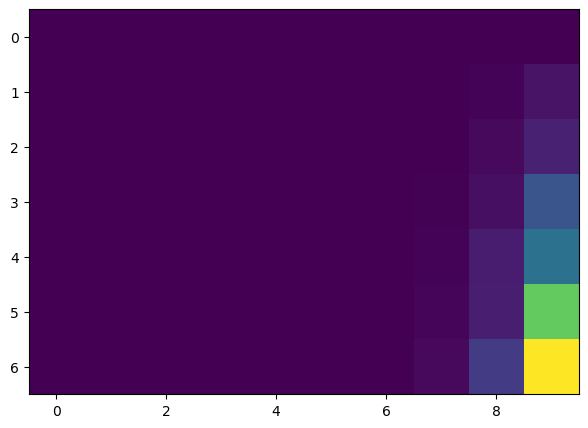

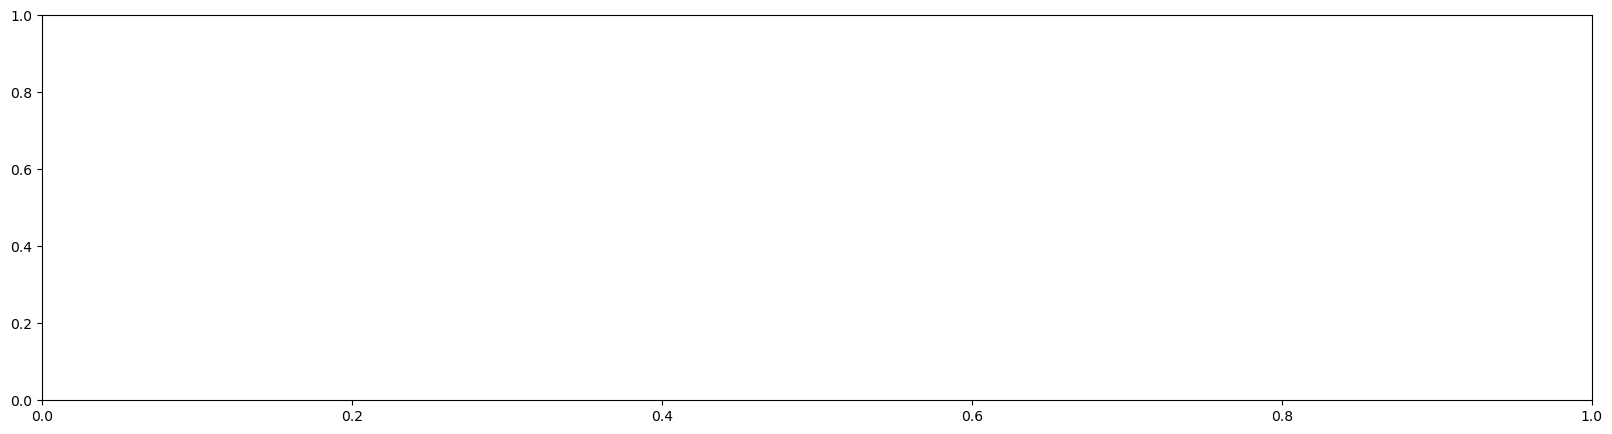

In [25]:
# Hamiltonian energy based error scaling
n_list = arange(1,8)
I = []
I_sym = []
std_I = []
std_I_sym = []
reps = 10
amp1s = logspace(-2,0,10)
rng = random.default_rng(100)

figsize = np.array([20,10])  # width, height
ratios = np.array([1, 1])
do_figures = 1
width = 8.5

s = 4
bins = 1
interval = 1.0
U = empty([s,s], dtype=complex)
U_classic = empty([s,s], dtype=complex)
line()
I = empty([len(n_list), len(amp1s)])
I_sym = empty([len(n_list), len(amp1s)])
std_I = empty([len(n_list), len(amp1s)])
std_I_sym = empty([len(n_list), len(amp1s)])
for k, n in enumerate(n_list):
    for i, amp1 in enumerate(amp1s):
        curr_I = empty(reps)
        curr_I_sym = empty(reps)
        for j in range(reps):
            amps = array([1.0, amp1])
            H_s = Random_parametric_Hamiltonian_Haar(n, s, amps, rng=rng)

            c_mins = zeros(n , dtype=np.double)
            c_maxs = interval*np.ones(n , dtype=np.double)
            c_bins = bins*np.ones(n, dtype=int)
            ui = UI(H_s, c_mins, c_maxs, c_bins)
            sym_ui = Sym_UI(H_s, c_mins, c_maxs, c_bins)
            system = Hamiltonian_System(H_s)

            c = interval/2 * ones(n)

            ui.expmH( c, U)
            system.expmH(c, U_classic)
            curr_I[j] = Av_Infidelity(U, U_classic)
            sym_ui.expmH( c, U)
            curr_I_sym[j] = Av_Infidelity(U, U_classic)
        I[k,i] = mean(curr_I)
        I_sym[k,i] = mean(curr_I_sym)
        std_I[k,i] = std(curr_I)
        std_I_sym[k,i] = std(curr_I_sym)
        print('n='+str(n)+' a='+str(amp1)+'  --> I(UI): '+str(I[-1]) + ' I(Sym UI): '+str(I_sym[-1]))

figs, axs = subplotter2multifigure(do_figures, figsize, ratios, horizontal=True)
ax1, ax2 = axs
labels = [r'$I$', r'$I_\mathrm{sym}$']
ax1.imshow(I)#, extent=(n_list[0], n_list[-1], amp1s[0], amp1s[1]), interpolation='spline16', vmin=0)
ax2.imshow(I_sym)
plt.set_cmap('viridis')
if do_figures:
    subfig_str = figs2tikz(figs, 'Infidelity', 'one_bin_infidelity_comparison_by_dimension_and_amplitude.tex', ratios, figsize, width=width, standalone=False, add_subfig=True, horizontal=True)
    print(subfig_str)

In [1]:
from useful import *
from discrete_quantum import *
from numpy import empty, arange, zeros, mean, linspace, random, diag
import numpy as np
from numba import njit

from timeit import *

from unipolator import *

from iplots import *
import matplotlib.pyplot as plt

In [11]:
from numpy.linalg import eigh
def Dag(U):
    return transpose(conj(U))

def expmH(H, dt = 1.0):
    E, V = eigh(H)
    return V @ diag(exp(-1j*E*dt)) @ Dag(V)

def expmH_from_H(H_s, x):
    n = H_s.shape[0]
    curr_H = H_s[0,:,:].copy()
    for j in range(1,n):
        curr_H += H_s[j,:,:]*x[j-1]
    U = expmH(curr_H)
    return U

def expmH_pulse(H_s, x):
    n_t = x.shape[0]
    i = 0
    U_c = expmH_from_H(H_s, x[0,:])
    for i in range(1,n_t):
        U_c = expmH_from_H(H_s, x[i,:]) @ U_c
    return U_c

def nb_dexpmH(H_s, x, eps = 10**-8):
    lx = len(x)
    s = H_s.shape[1]
    U_c = expmH_from_H(H_s, x)
    dU_c = np.empty((lx, s, s), dtype=np.complex128)
    for i in range(lx):
        di = zeros(lx)
        di[i] += eps
        dU_c[i,:,:] = (expmH_from_H(H_s, x+di)-U_c)/eps
    return U_c, dU_c

def Infidelity(U_tar, U):
    n = U.shape[0]
    I = n/(n+1)-1/(n*(n+1))*abs(trace(transpose(conj(U_tar)) @ U ))**2
    return I

def nb_dexpmH_pulse(U_tar, H_s, x, eps = 10**-7): # with finite differences
    n_t = x.shape[0]
    lx = x.shape[1]
    i = 0
    n = H_s.shape[1]
    d = H_s.shape[0]-1
    dI_dj = zeros([n_t, lx])
    U_c = expmH_pulse(H_s, x)
    I = Infidelity(U_tar, U_c)
    Q = U_c.copy()
    P = diag(ones(n))+0j
    for i in range(n_t):
        Ui = expmH_from_H(H_s, x[i,:])
        Q = Q @ Dag(Ui)
        for j in range(lx):
            dj = zeros(lx)
            dj[j] = eps
            Ui_plus = expmH_from_H(H_s, x[i,:]+dj)
            U_tmp =  Q  @ Ui_plus  @ P
            I_plus = Infidelity(U_tar, U_tmp)
            dI_dj[i,j] = ( I_plus - I ) / eps
        P = Ui @ P
    return I, dI_dj
#Infidelity(U_tar, U)
#I_nb, dI_dj_nb = nb_dexpmH_pulse(U_tar, H_s, x, eps = 10**-8)

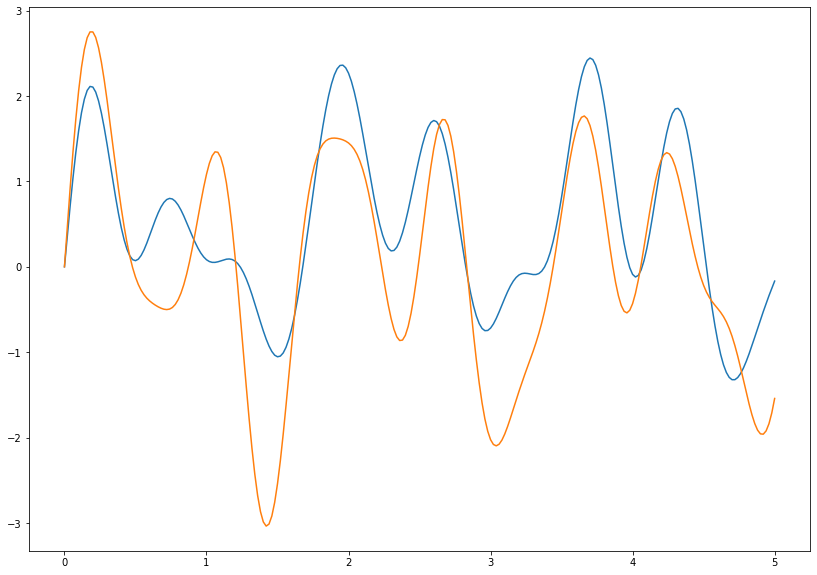

In [12]:
rng = random.default_rng(100)
n = 2
s = 2
bins = 100

# Generate pulse
t_max = 5
dt = 0.02
n_t = int(t_max/dt)+1
t = linspace(0,t_max, n_t)
dt = t[1]-t[0]
x = zeros([n_t, n])
f_max = 2.0
n_freqs = 5
A_max = 1
for i in range(n):
    frequencies = rng.random(n_freqs)*f_max
    Amplitudes = rng.random(n_freqs)*A_max
    for j in range(n_freqs):
        x[:,i] += sin(frequencies[j]*2*pi*t)*Amplitudes[j]
# x_norm = x*dt

fig, ax = plt.subplots(1, 1, figsize=(14,10))
for i in range(n):
    ax.plot( t, x[:,i])

In [13]:
# Pulse Evolution (Infidelity)
H_s = np.empty([n+1,s,s], dtype=np.complex128)
for i in range(n+1):
    H_s[i,:,:] = randH_Haar(s, amp=0.1, rng=rng)*dt

c_mins = -np.ones(n)*A_max*n_freqs
c_maxs = np.ones(n)*A_max*n_freqs
c_bins = bins*np.ones(n, dtype=int)
ui = UI(H_s, c_mins, c_maxs, c_bins)
system = Hamiltonian_System(H_s)

U = np.empty([s,s], dtype=complex)
U_c = np.empty([s,s], dtype=complex)

ui.expmH_pulse(x, U)
system.expmH_pulse(x, U_c)

I = Av_Infidelity(U, U_c)
print(I)

2.0761170560490427e-14


In [14]:
system.expmH_pulse(x, U_c)

U_new = np.empty([s,s], dtype=complex)
U_class = diag(ones(s, dtype=complex))
for i in range(n_t):
    system.expmH(x[i,:], U_new)
    U_class = U_new @ U_class

max(abs(U_c-U_class))

2.1677797545656835e-15

In [15]:
# Differential
U = np.empty([s,s], dtype=complex)
U_ui = np.empty([s,s], dtype=complex)
dU = np.empty([n,s,s], dtype=complex)
dU_ui = np.empty([n,s,s], dtype=complex)
system.dexpmH(x[0,:], U, dU)
ui.dexpmH(x[0,:], U_ui, dU_ui)
U_c, dU_c = nb_dexpmH(H_s, x[0,:])

print(mabs(dU-dU_c))
print(mabs(dU-dU_ui))
print(mabs(dU_c-dU_ui))

4.2346223952512275e-08
8.152637793864075e-08
9.132366796397939e-08


In [16]:
print(mabs(U-U_c))
print(mabs(U-U_ui))
print(mabs(U_c-U_ui))

2.220446049250313e-16
4.440892098500626e-16
4.1231768151229377e-16


In [29]:
# Do grape
import discrete_quantum as dq
U_tar = dq.randU(s)
DagU_tar = np.empty([s,s], dtype=complex)
Dag_fast(U_tar, DagU_tar)
U = np.empty([s,s], dtype=complex)
dU = np.empty([n, s, s], dtype=complex)
dI_dj = np.zeros([n_t, n])
dI_dj_eigh = np.zeros([n_t, n])
target_indexes = arange(s)
print('Calculating GRAPE with unitary interpolation and analytical gradients.')
I0 = ui.grape(x, U_tar, target_indexes, U, dU, dI_dj )
print('Calculating GRAPE with eigh and analytical gradients.')
I0_eigh = system.grape(x, U_tar, target_indexes, U, dU, dI_dj_eigh )
print('Calculating GRAPE with eigh approach and finite difference gradients.')
I_nb, dI_dj_nb = nb_dexpmH_pulse(U_tar, H_s, x)
line('Relative Error')
print('    --> Maximum relative error (ui - eigh (analytical)) : '+ str(mabs((dI_dj_eigh - dI_dj)/dI_dj)))
print('    --> Maximum relative error (ui - eigh (finite diff)): '+ str(mabs((dI_dj_nb - dI_dj)/dI_dj)))
line('Absolute Error')
print('    --> Maximum absolute error (ui - eigh (analytical)) : '+ str(mabs(dI_dj_eigh - dI_dj)))
print('    --> Maximum absolute error (ui - eigh (finite diff)): '+ str(mabs(dI_dj_nb - dI_dj)))

Calculating GRAPE with unitary interpolation and analytical gradients.
Calculating GRAPE with eigh and analytical gradients.
Calculating GRAPE with eigh approach and finite difference gradients.
————— Relative Error ———————————————————————————————————————————————————————————
    --> Maximum relative error (ui - eigh (analytical)) : 0.00013004195855766877
    --> Maximum relative error (ui - eigh (finite diff)): 0.00015200648738721988
————— Absolute Error ———————————————————————————————————————————————————————————
    --> Maximum absolute error (ui - eigh (analytical)) : 4.518882243051414e-08
    --> Maximum absolute error (ui - eigh (finite diff)): 5.282136814158426e-08


In [ ]:
line('Computational Time for Pulse:')
print('Unitary Interpolation: ', end='')
ui_time = %timeit -o ui.expmH_pulse(x, U)
print('ExpmH:                 ', end='')
expmh_time = %timeit -o expmH_pulse(H_s, x)

ratio = expmh_time.average / ui_time.average
std_ratio = expmh_time.stdev / ui_time.average + expmh_time.average / ui_time.average**2 * ui_time.stdev
dline()
print('Speedup Ratio:         '+ '{0:0.2f}'.format(ratio) + ' ± ' + '{0:0.2f}'.format(std_ratio))

In [ ]:
# Differential
rng = random.default_rng(125)
for n in range(3,5):#n =
    s = 2
    bins = 1
    H_s = np.empty([n+1,s,s], dtype=np.complex128)
    for i in range(n+1):
        H_s[i,:,:] = randH_Haar(s, amp=0.001, rng=rng)

    c_mins = np.zeros(n)
    c_maxs = np.ones(n)
    c_bins = bins*np.ones(n, dtype=int)
    d_ind = arange(n)
    ui = UI(H_s, c_mins, c_maxs, c_bins, d_ind)

    U = np.empty([s,s], dtype=complex)
    c = rng.random(n)
    dU = np.empty([len(d_ind),s,s], dtype=complex)
    ui.dexpmH(c, U, dU)
    U_c, dU_c = dexpmH(H_s, c, 10**-5)
    print(dU[:,0,0])
    line()
    print(dU_c[:,0,0])
    dline()
#print(dU-dU_c)

In [ ]:
# Add expmH to exp_and_log.pyx ->

In [ ]:
from useful import *
from discrete_quantum import *
from numpy import empty, arange, zeros, mean, linspace, random, diag
import numpy as np
from numba import njit

from timeit import *

from unipolator import *
import unipolatorold as ui_old

from iplots import *
import matplotlib.pyplot as plt

In [ ]:
# Test Grape algorithm of unitary interpolation
rng = random.default_rng(100)
n = 2
s = 2
bins = 10

# Generate pulse
t_max = 5
dt = 0.02
n_t = int(t_max/dt)+1
t = linspace(0,t_max, n_t)
dt = t[1]-t[0]
x = zeros([n_t, n])
f_max = 2.0
n_freqs = 5
A_max = 1
for i in range(n):
    frequencies = rng.random(n_freqs)*f_max
    Amplitudes = rng.random(n_freqs)*A_max
    for j in range(n_freqs):
        x[:,i] += sin(frequencies[j]*2*pi*t)*Amplitudes[j]

H_s = np.empty([n+1,s,s], dtype=np.complex128)
for i in range(n+1):
    H_s[i,:,:] = randH_Haar(s, amp=0.1, rng=rng)*dt

c_mins = -np.ones(n)*A_max*n_freqs
c_maxs = np.ones(n)*A_max*n_freqs
c_bins = bins*np.ones(n, dtype=int)
ui = UI(H_s, c_mins, c_maxs, c_bins)

which_diffs = arange(n)
ui.set_which_diffs(which_diffs)

U = np.empty([s,s], dtype=complex)
U_tar = randU(s, rng=rng)
target_indexes = arange(s)
U = empty([s, s], dtype=complex)
dU = empty([n, s, s], dtype=complex)
I0 = 0
dI_dj = zeros([n_t, n])
ui.grape(x, U_tar, target_indexes, U, dU, I0, dI_dj)

In [ ]:
I0

In [ ]:
U_tar = randU(s, rng=rng)
U_tar

In [ ]:
U

In [ ]:
abs_2(1+1j)